In [ ]:
!pip -q install lime shap

# 0) Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

from lime import lime_image
from skimage.segmentation import slic

import shap
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1) Load & Prepare MNIST

In [ ]:
# MNIST: 28x28 grayscale digits, labels 0..9
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Scale to [0,1] floats for stable training
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


# Add channel dim for CNN: (N, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# Keep original labels for readability, but also build one-hot if needed
num_classes = 10

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#2) Build & Train a CNN

In [ ]:
# Small CNN: Conv → Conv → MaxPool → Dropout → Dense
model = models.Sequential([
layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
layers.Conv2D(64, (3,3), activation='relu'),
layers.MaxPooling2D((2,2)),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dropout(0.5),
layers.Dense(num_classes, activation='softmax')
])

# Compile with standard categorical cross-entropy and Adam
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

# Train briefly to keep runtime reasonable in Colab (2–3 epochs are enough for ~99% test acc)
history = model.fit(
x_train, y_train,
validation_split=0.1,
epochs=3, # bump to 5–10 for higher accuracy if desired
batch_size=128,
verbose=1
)

# Evaluate on test set and print accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 132s 305ms/step - accuracy: 0.8370 - loss: 0.5089 - val_accuracy: 0.9848 - val_loss: 0.0547
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 131s 280ms/step - accuracy: 0.9714 - loss: 0.0946 - val_accuracy: 0.9880 - val_loss: 0.0436
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 137s 267ms/step - accuracy: 0.9792 - loss: 0.0707 - val_accuracy: 0.9892 - val_loss: 0.0381
Test accuracy: 0.9904


# 3) Pick 5 test images for explanations

In [ ]:
# We choose them randomly but reproducibly and ensure they are stored for reuse
rng = np.random.default_rng(RANDOM_STATE)
idx5 = rng.choice(np.arange(len(x_test)), size=5, replace=False)
X5 = x_test[idx5] # shape (5, 28, 28, 1)
y5 = y_test[idx5] # ground-truth labels
print("Chosen test indices:", idx5.tolist())


# Helper: model predict_proba wrapper expected by LIME (returns NxK probabilities)
def predict_proba(images):
    # LIME may pass images as float arrays; ensure correct shape and dtype
    if images.ndim == 3: # (H, W, C) single image case
        images = np.expand_dims(images, 0)
    return model.predict(images, verbose=0)

Chosen test indices: [7737, 4388, 6544, 892, 4330]


# 4) LIME Explanations for the 5 images

  0%|          | 0/1000 [00:00<?, ?it/s]

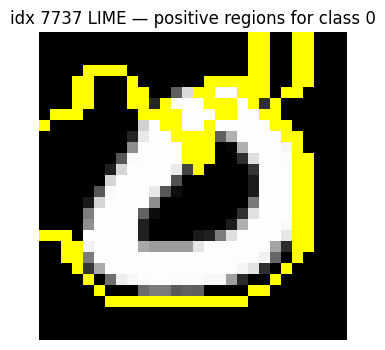

  0%|          | 0/1000 [00:00<?, ?it/s]

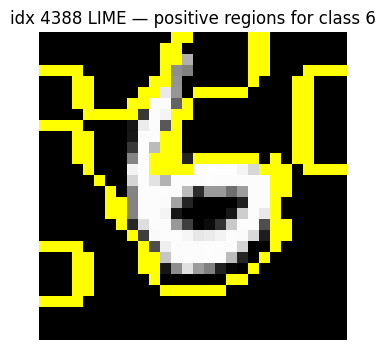

  0%|          | 0/1000 [00:00<?, ?it/s]

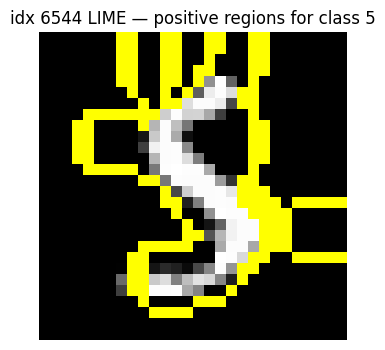

  0%|          | 0/1000 [00:00<?, ?it/s]

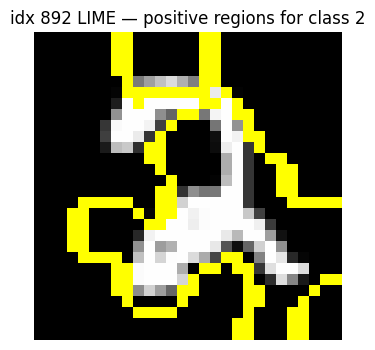

  0%|          | 0/1000 [00:00<?, ?it/s]

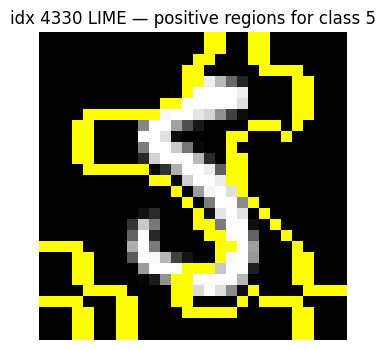

In [ ]:
# Define a segmentation function for LIME using SLIC superpixels
segmentation_fn = lambda img: slic(
    img, n_segments=50, compactness=10, sigma=1, start_label=0
)


# Create a LIME image explainer
lime_explainer = lime_image.LimeImageExplainer()


# Function to visualize LIME masks for a given image and class
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries


def show_lime_explanation(image, explanation, class_id, title_prefix=""):
    # Get mask for positive regions (features pushing towards the class)
    temp, mask = explanation.get_image_and_mask(
        label=class_id, positive_only=True, hide_rest=False,
        num_features=10, min_weight=0.0
    )
    plt.figure(figsize=(4,4))
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')
    plt.title(f"{title_prefix} LIME — positive regions for class {class_id}")
    plt.show()


# Run LIME for each of the 5 images
lime_explanations = []
for i, idx in enumerate(idx5):
    img = X5[i]
    # LIME expects 3-ch images; convert grayscale to 3-ch for segmentation/visualization
    img3 = gray2rgb(img.squeeze())
    explanation = lime_explainer.explain_instance(
        image=img3,
        classifier_fn=lambda im: predict_proba(np.expand_dims(im[...,0], -1)),
        top_labels=1,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=segmentation_fn
    )
    lime_explanations.append(explanation)
    pred_class = np.argmax(model.predict(img[None,...], verbose=0)[0])
    show_lime_explanation(img3, explanation, pred_class, title_prefix=f"idx {int(idx)}")

# 5) SHAP Explanations (DeepExplainer) for the same 5 images

Shape of rearranged_shap_values: (28, 28, 1, 10, 5)
Predicted classes (preds): [0 6 5 2 5]
Inside loop - i: 0, pred_c: 0


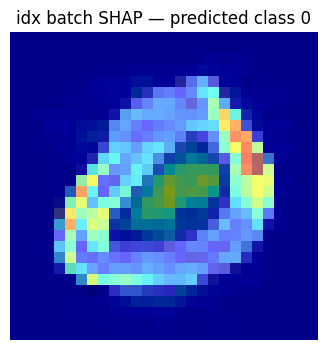

Inside loop - i: 1, pred_c: 6


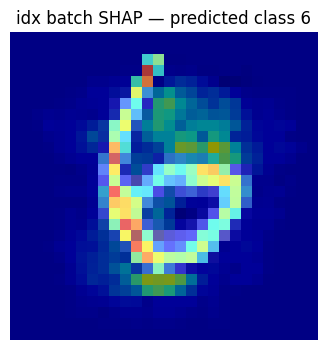

Inside loop - i: 2, pred_c: 5


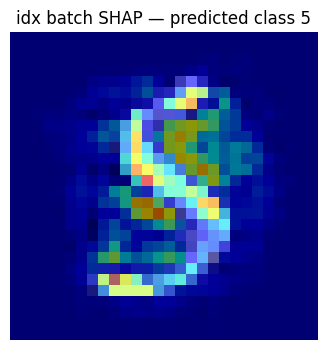

Inside loop - i: 3, pred_c: 2


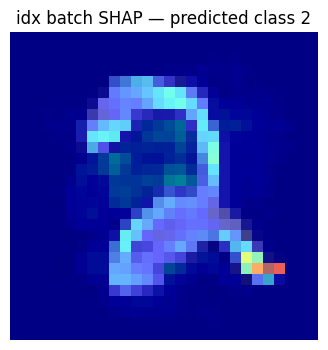

Inside loop - i: 4, pred_c: 5


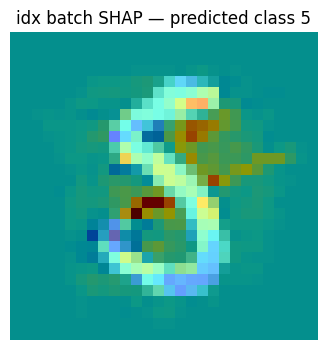

In [ ]:
# Select a small background set (e.g., 100 images) to keep it fast
background = x_train[rng.choice(np.arange(len(x_train)), size=100, replace=False)]


# Create the SHAP DeepExplainer on our trained model
# For classification, we'll take SHAP values for the predicted class per image
explainer = shap.DeepExplainer(model, background)


# Compute SHAP values for our 5 images; returns a list (one array per output class)
# We request SHAP values for all classes then index per-sample at the predicted class
shap_values_all = explainer.shap_values(X5) # list of length num_classes, each shape (5, 28, 28, 1)


# Rearrange SHAP values to have shape (height, width, channels, num_classes, num_samples)
# Based on the observed shape (28, 28, 1, 10, 5)
rearranged_shap_values = np.stack(shap_values_all, axis=4) # Stack along a new axis at the end


print(f"Shape of rearranged_shap_values: {rearranged_shap_values.shape}")


# Visualization helper for SHAP heatmaps
def show_shap_for_pred(image_batch, shap_values_arr, title_prefix=""):
    # Determine predicted classes for this batch
    preds = np.argmax(model.predict(image_batch, verbose=0), axis=1)
    print(f"Predicted classes (preds): {preds}")
    for i, pred_c in enumerate(preds):
        print(f"Inside loop - i: {i}, pred_c: {pred_c}")
        # Access SHAP values for the i-th image and the predicted class based on observed shape (28, 28, 1, 10, 5)
        sv = shap_values_arr[:, :, :, pred_c, i].squeeze()
        plt.figure(figsize=(4,4))
        # SHAP has a nice utility for image plots, but we'll use a simple heatmap overlay
        plt.imshow(image_batch[i].squeeze(), cmap='gray')
        plt.imshow(sv, cmap='jet', alpha=0.6) # overlay contributions
        plt.axis('off')
        plt.title(f"{title_prefix} SHAP — predicted class {pred_c}")
        plt.show()


show_shap_for_pred(X5, rearranged_shap_values, title_prefix="idx batch")

# 6) Quick side-by-side textual comparison

In [ ]:
for i, idx in enumerate(idx5):
    pred = np.argmax(model.predict(X5[i:i+1], verbose=0)[0])
    print(f"\nImage test idx {int(idx)} — predicted class {pred}")
    print(" LIME: shows contiguous superpixels (strokes) that, when turned off/on, change the prediction.")
    print(" SHAP: shows fine-grained pixel contributions—warm colors push toward the predicted class;"
          " cool colors push away. Often aligns with the digit's main strokes but may highlight"
          " thinner edges or counter-evidence too.")


Image test idx 7737 — predicted class 0
 LIME: shows contiguous superpixels (strokes) that, when turned off/on, change the prediction.
 SHAP: shows fine-grained pixel contributions—warm colors push toward the predicted class; cool colors push away. Often aligns with the digit's main strokes but may highlight thinner edges or counter-evidence too.

Image test idx 4388 — predicted class 6
 LIME: shows contiguous superpixels (strokes) that, when turned off/on, change the prediction.
 SHAP: shows fine-grained pixel contributions—warm colors push toward the predicted class; cool colors push away. Often aligns with the digit's main strokes but may highlight thinner edges or counter-evidence too.

Image test idx 6544 — predicted class 5
 LIME: shows contiguous superpixels (strokes) that, when turned off/on, change the prediction.
 SHAP: shows fine-grained pixel contributions—warm colors push toward the predicted class; cool colors push away. Often aligns with the digit's main strokes but may

## Comparison of LIME and SHAP Explanations

Based on the visualizations and the brief textual comparison, here are the key differences and similarities between the LIME and SHAP explanations for the MNIST digit classifications:

**Similarities:**

*   **Highlight Important Regions:** Both LIME and SHAP successfully highlight the regions (pixels or superpixels) of the input image that are most important for the model's prediction of the predicted class. For the digit images, both methods tend to focus on the strokes and key features that define the digit.
*   **Local Explanations:** Both LIME and SHAP provide local explanations, meaning they explain the prediction for a single instance (image) rather than providing a global explanation of the entire model.

**Differences:**

*   **Methodology:**
    *   **LIME (Local Interpretable Model-agnostic Explanations):** Works by creating a local approximation of the model around the instance being explained. It perturbs the input (e.g., turning superpixels on/off in images), gets predictions for these perturbed instances, and trains a simple, interpretable model (like a linear model) on this locally sampled data. The explanation is based on the features (superpixels) that are important in this local, interpretable model. LIME's output shows contiguous regions (superpixels) that influence the prediction.
    *   **SHAP (SHapley Additive exPlanations):** Based on the concept of Shapley values from cooperative game theory. SHAP aims to attribute the prediction to each feature (pixel) by considering all possible combinations of features. For image data and deep learning models, `DeepExplainer` (used here) approximates SHAP values by considering the difference in expected output when conditioning on different subsets of input features. SHAP provides fine-grained pixel-level attributions, showing both positive (contributing to the predicted class) and negative (contributing against the predicted class) influences.
*   **Output Representation:**
    *   **LIME:** Typically shows explanations as masks or outlines on the image, highlighting superpixels. The color usually indicates the direction of influence (e.g., green for supporting the class, red for opposing).
    *   **SHAP:** Provides pixel-level heatmaps showing the magnitude and direction of influence. Warm colors (e.g., red/yellow) often indicate features that strongly support the prediction, while cool colors (e.g., blue/cyan) indicate features that strongly oppose it.
*   **Granularity:**
    *   **LIME:** Explanations are based on superpixels (groups of pixels), providing a coarser but often more human-interpretable view of important regions.
    *   **SHAP:** Provides explanations at the individual pixel level, offering a more detailed view of feature importance.
*   **Computational Cost:**
    *   **LIME:** Can be computationally expensive for images as it requires generating and predicting on many perturbed versions of the input. The `num_samples` parameter controls this cost.
    *   **SHAP (DeepExplainer):** Requires a background dataset and can also be computationally intensive, especially for large models and datasets. However, it can be more efficient than LIME for deep learning models due to optimizations.
*   **Interpretation:**
    *   **LIME:** Highlights which *regions* (superpixels) are important. It shows the effect of including/excluding these regions.
    *   **SHAP:** Shows how much each *pixel* contributes to the prediction compared to the expected value. It provides a sense of the "push" and "pull" of individual pixels towards or away from the predicted class.

In summary, both LIME and SHAP are valuable tools for understanding deep learning model predictions on images. LIME offers a superpixel-based, locally linear approximation view, while SHAP provides a pixel-level attribution based on game theory. The choice between them often depends on the desired granularity of explanation and computational resources.

Done: CNN trained, LIME and SHAP explanations generated for 5 images,"
      " and a brief comparison printed. Add more epochs if you want higher accuracy,"
      " or increase LIME num_samples for denser local fits.